In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d odins0n/ucf-crime-dataset

In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Mini Project/ucf-crime-dataset.zip','r')
# zip_ref.extractall('/content/drive/MyDrive/Mini Project')
# zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Mini Project

/content/drive/.shortcut-targets-by-id/1VtrHAGKqc3-YeQW8HegAtNpR5rXkgbN4/Mini Project


In [ ]:
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import os
import random
import pickle
import matplotlib.pyplot as plt

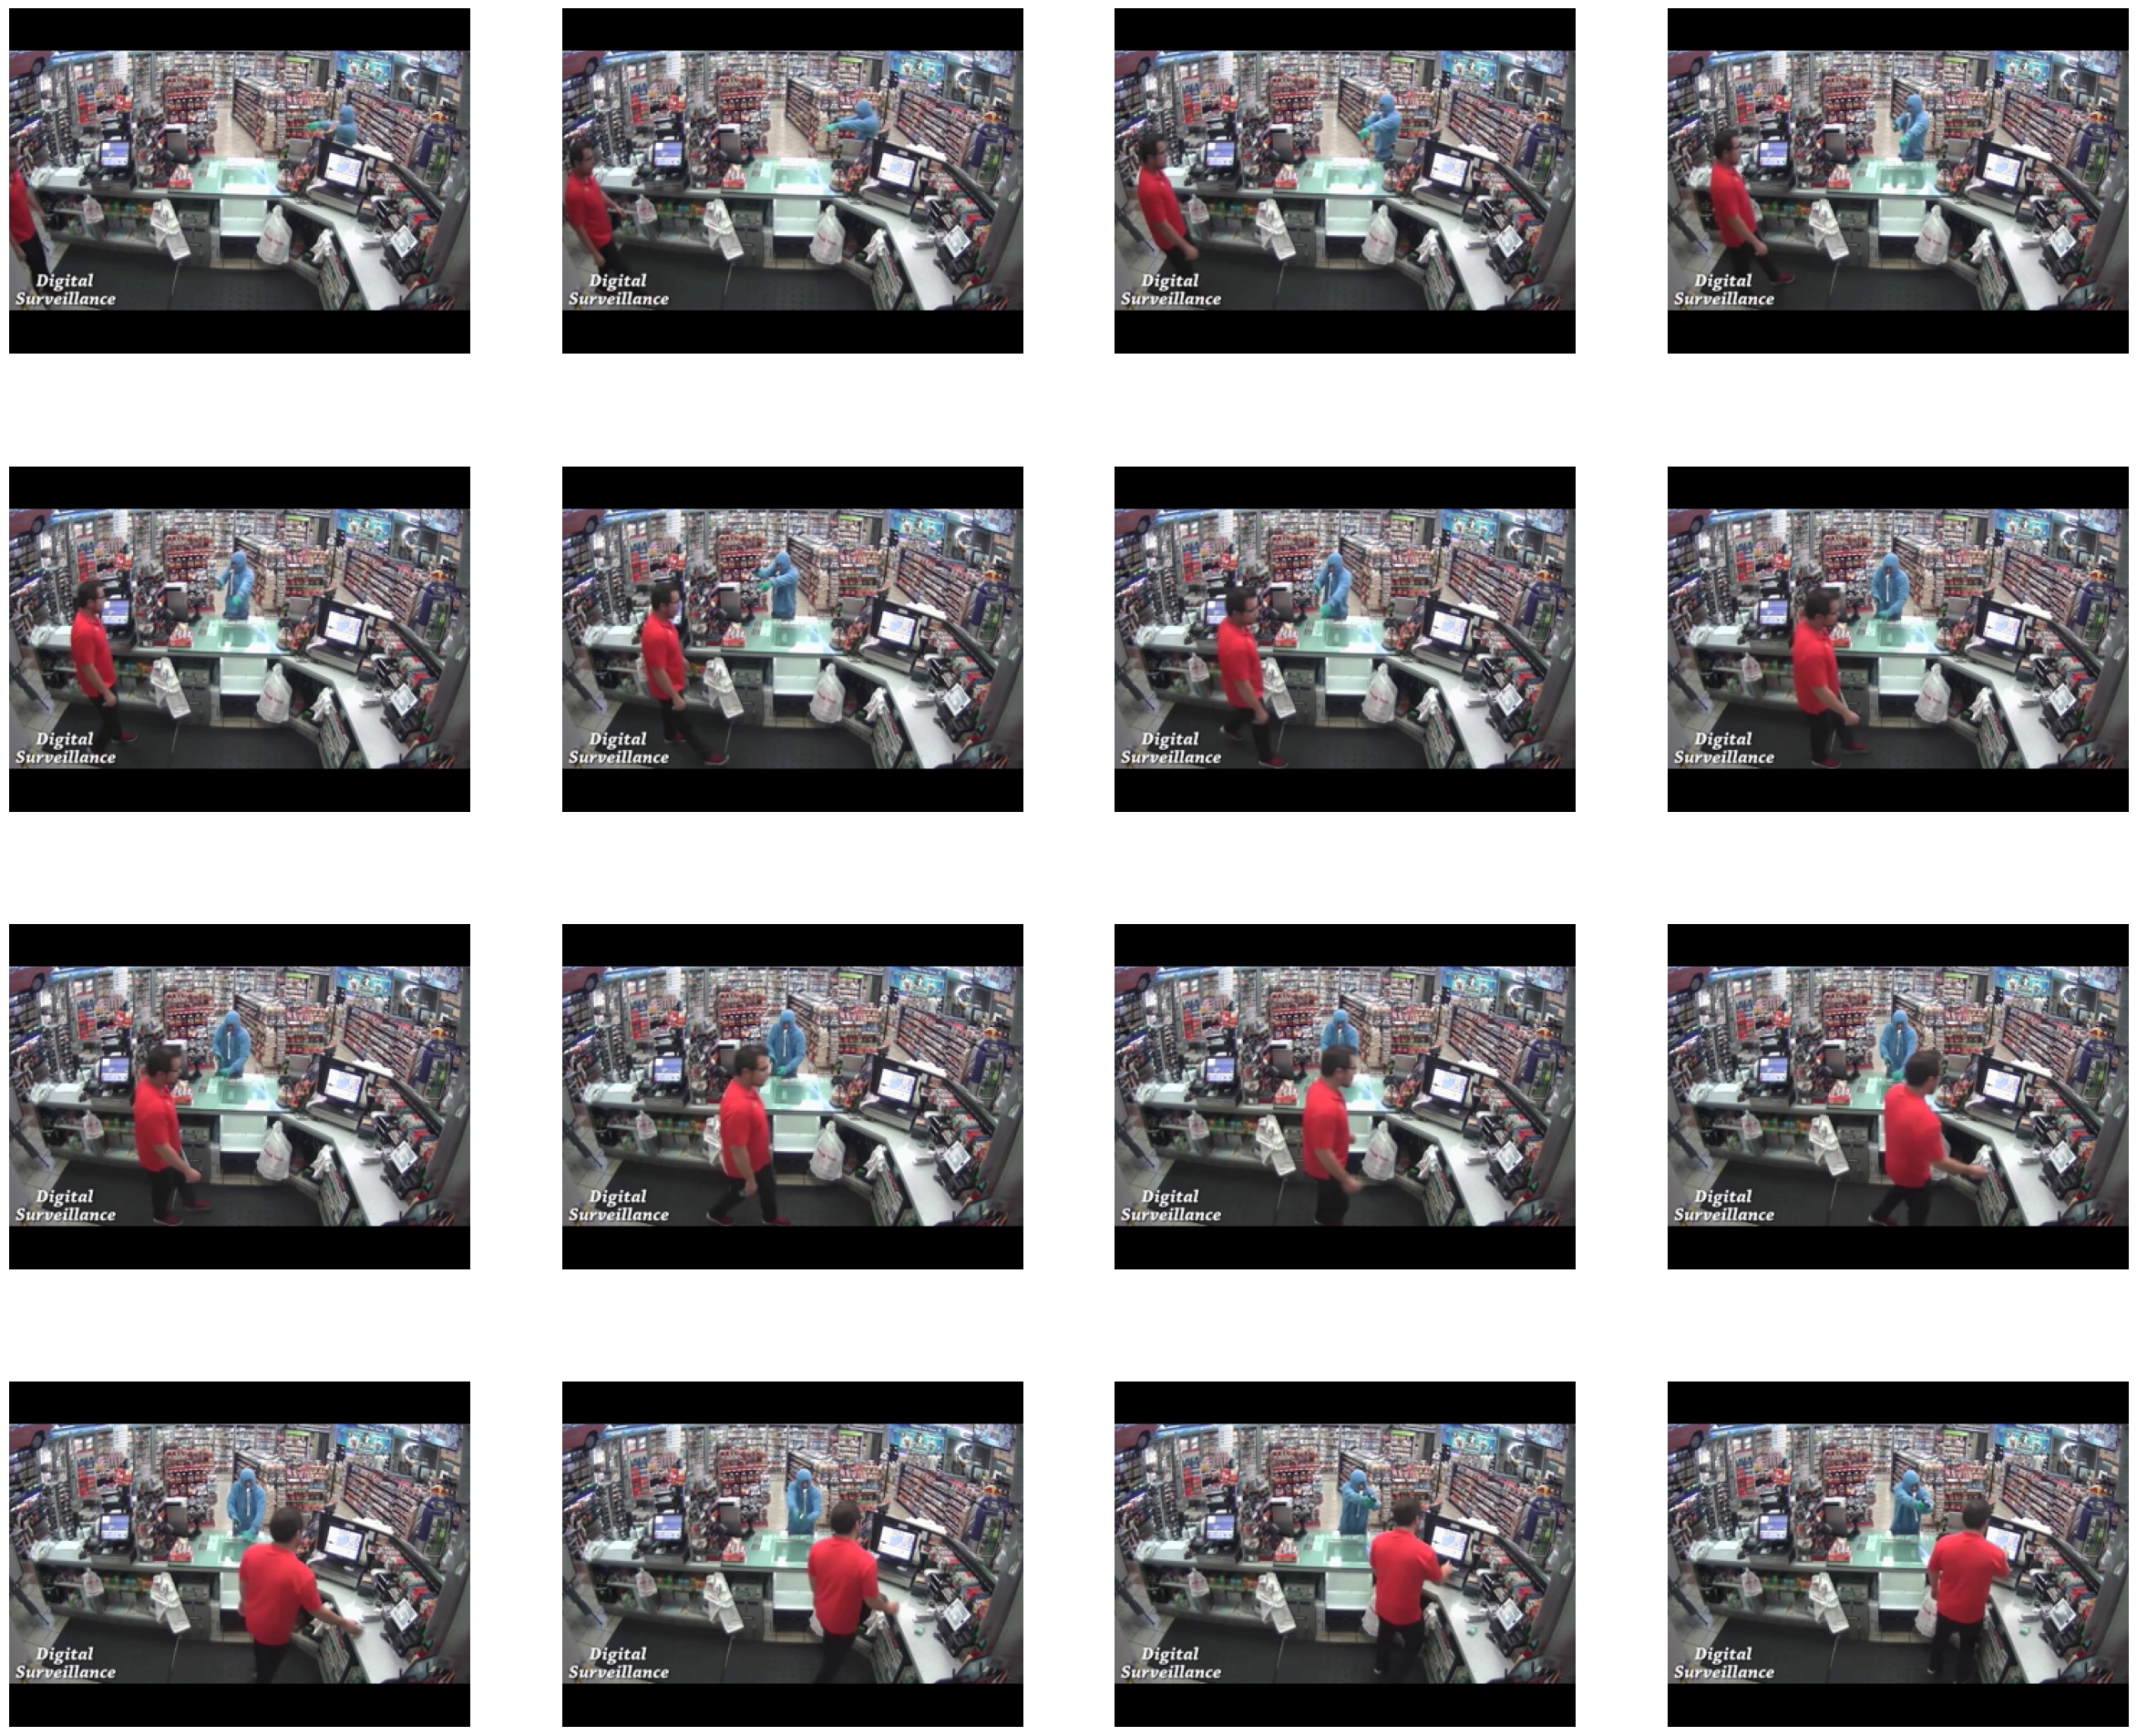

In [ ]:
sequence_length = 16

video_reader = cv2.VideoCapture('/content/drive/MyDrive/Mini Project/precrime_dataset/Robbery/Robbery005_x264.mp4')
video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # CAP_PROP_FRAME_COUNT counts the number of frames in the video
skip_frames_window = max(int(video_frames_count/sequence_length), 1)

plt.figure(figsize = (30, 25))

for frame_counter in range(1, sequence_length+1):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) # CAP_PROP_POS_FRAMES sets the current frame position
    success, frame = video_reader.read()
    rg_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, frame_counter)
    plt.imshow(rg_frame)
    plt.axis('off')

In [ ]:
def video_paths(base_folder, categories):
    video_list = []
    for category in categories:
        folder_path = os.path.join(base_folder, category)
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(('.mp4')):
                    video_list.append(os.path.join(root, file))
    return video_list

categories = ['Normal', 'Robbery', 'Shoplifting', 'Stealing']
video_list = video_paths("precrime_dataset", categories)

In [ ]:
normal_count = 0
anomaly_count = 0
for video_path in video_list:
  if(video_path.split('/')[1] == "Normal"):
    normal_count = normal_count + 1
  else:
    anomaly_count = anomaly_count + 1

print(f'Normal Videos: {normal_count}')
print(f'Suspicious Videos: {anomaly_count}')

Normal Videos: 100
Suspicious Videos: 100


In [ ]:
def split_dataset(video_list, train_ratio=0.7):
    random.shuffle(video_list)
    train_size = int(len(video_list) * train_ratio)
    train_videos = video_list[:train_size]
    test_videos = video_list[train_size:]
    return train_videos, test_videos

# Spliting dataset into training and testing sets
train_videos, test_videos = split_dataset(video_list)

print("Training Videos:", len(train_videos), train_videos)
print("Testing Videos:", len(test_videos), test_videos)

Training Videos: 140 ['precrime_dataset/Shoplifting/Shoplifting044_1x264.mp4', 'precrime_dataset/Robbery/Robbery008_x264.mp4', 'precrime_dataset/Shoplifting/Shoplifting016_1x264.mp4', 'precrime_dataset/Robbery/Robbery143_x264.mp4', 'precrime_dataset/Normal/Normal_Videos_893_x264.mp4', 'precrime_dataset/Robbery/Robbery145_x264.mp4', 'precrime_dataset/Normal/Normal_Videos630_x264.mp4', 'precrime_dataset/Shoplifting/Shoplifting034_1x264.mp4', 'precrime_dataset/Normal/Normal_Videos096_x264.mp4', 'precrime_dataset/Stealing/Stealing096_x264.mp4', 'precrime_dataset/Stealing/Stealing047_x264.mp4', 'precrime_dataset/Normal/Normal_Videos_439_x264.mp4', 'precrime_dataset/Robbery/Robbery040_1x264.mp4', 'precrime_dataset/Shoplifting/Shoplifting028_x264.mp4', 'precrime_dataset/Stealing/Stealing105_x264.mp4', 'precrime_dataset/Robbery/Robbery009_x264.mp4', 'precrime_dataset/Stealing/Stealing078_1x264.mp4', 'precrime_dataset/Normal/Normal_Videos_100_x264.mp4', 'precrime_dataset/Robbery/Robbery021_x264

In [ ]:
def preprocess_video(video_path, sequence_length=16):

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_count = max(int(video_frames_count/sequence_length), 1)

    frames = []
    for frame_counter in range(1, sequence_length+1):
       video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_count)
       success, frame = video_reader.read()
       if not success:
            break
       frame = cv2.resize(frame, (224, 224))
       frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
       frame = np.expand_dims(frame, axis=-1)
       frames.append(frame)

       if len(frames) == sequence_length:
            break
    video_reader.release()
    frames = np.array(frames)
    frames = frames / 255.0
    return frames

In [ ]:
train_videos[1].split("/")[1]

'Robbery'

In [ ]:
def load_dataset(video_paths, segment_length=16):
    X = []
    Y = []
    for video_path in video_paths:
        frames = preprocess_video(video_path, segment_length)
        if len(frames) == segment_length:
            if(video_path.split('/')[1] == "Normal"):
              Y.append(0)
            else:
              Y.append(1)
            X.append(frames)
    X = np.array(X)
    Y = np.array(Y)
    Y.reshape((Y.shape[0], 1))
    return X, Y

# Load training and testing datasets
X_train, Y_train = load_dataset(train_videos)
X_test, Y_test = load_dataset(test_videos)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(131, 16, 224, 224, 1)
(56, 16, 224, 224, 1)
(131,)
(56,)


In [ ]:
# Saving train and test features
with open('/content/drive/MyDrive/Mini Project/precrime_dataset/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('/content/drive/MyDrive/Mini Project/precrime_dataset/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('/content/drive/MyDrive/Mini Project/precrime_dataset/Y_train.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

with open('/content/drive/MyDrive/Mini Project/precrime_dataset/Y_test.pkl', 'wb') as f:
    pickle.dump(Y_test, f)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, TimeDistributed, LSTM, Dense, Flatten, Dropout

def create_3dcnn_lstm_model(input_shape):

    model = Sequential()

    # 3D CNN layers
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten layer
    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))

    # Dense layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (16, 224, 224, 1)
model = create_3dcnn_lstm_model(input_shape)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)                    │ (None, 16, 224, 224, 32)    │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 8, 112, 112, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 8, 112, 112, 64)     │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 4, 56, 56, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 4, 56, 56, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 2, 28, 28, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 2, 100352)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 2, 64)               │      25,706,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,996,769 (99.17 MB)

 Trainable params: 25,996,769 (99.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Training model
model.fit(X_train, Y_train, epochs=30, batch_size=4, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.4706 - loss: 0.7062 - val_accuracy: 0.4444 - val_loss: 0.6981
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.5978 - loss: 0.6830 - val_accuracy: 0.7037 - val_loss: 0.6608
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.6648 - loss: 0.6290 - val_accuracy: 0.7407 - val_loss: 0.6363
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7128 - loss: 0.5431 - val_accuracy: 0.7407 - val_loss: 0.6505
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.7818 - loss: 0.4942 - val_accuracy: 0.7407 - val_loss: 0.6014
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8099 - loss: 0.4147 - val_accuracy: 0.6667 - val_loss: 0.6063
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8357 - loss: 0.3742 - val_accuracy: 0.7407 - val_loss: 0.6424
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9235 - loss: 0.2937 - val_accuracy: 

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6815 - loss: 0.9436
Test Loss: 0.9641384482383728
Test Accuracy: 0.6785714030265808


In [ ]:
Y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step


In [ ]:
model.save('/content/drive/MyDrive/Mini Project/anomaly_detection_model.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


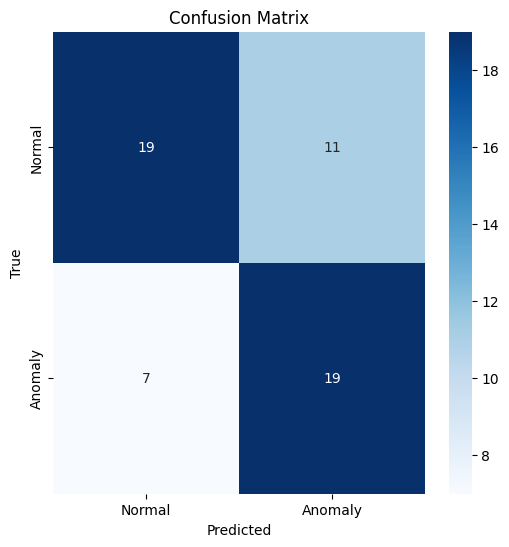

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)
cm = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
